In [ ]:
from jax import random, jit, vmap
from functions.simulation import get_dataset, get_epsilon_star
from functions.training import train_loop
from functions.SBC import SBC_epsilon, plot_SBC
from jax.scipy.special import expit, logit
import jax.numpy as jnp
import time
import pickle 
import lzma
import matplotlib.pyplot as plt
import seaborn as sns

@jit
def prior_simulator(key):
    return random.normal(key, (1,))*SIGMA0 + MU0

@jit
def data_simulator(key, beta):
    key, key_betas= random.split(key)
    betas = jnp.insert(random.normal(key_betas, (N_VAR-1,))*SIGMA0 + MU0, INDEX_BETA, beta)
    probs = expit(jnp.dot(X_DESIGN, betas))
    return random.bernoulli(key, probs).astype(float)

@jit
def discrepancy(y, y_true):
    return jnp.mean((y-y_true)**2)


key = random.PRNGKey(1)

N_VAR = 5
N_DATA = 100
INDEX_BETA = 0

def x_design_simulator(key):
    return random.normal(key, (N_DATA, N_VAR))

key, key_design = random.split(key)
X_DESIGN = x_design_simulator(key_design)

MU0, SIGMA0 = 0., 10.
PRIOR_ARGS = [MU0, SIGMA0]

SIGMA = 1.
MODEL_ARGS = [SIGMA, X_DESIGN]


from jax.scipy.stats import norm
PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)


key, key_beta = random.split(key)
key, key_beta2 = random.split(key)
TRUE_BETAS = jnp.append(jnp.array([15.]), random.normal(key_beta, (N_VAR-2,))*5. + MU0)
TRUE_BETAS = jnp.append(TRUE_BETAS, jnp.array([.1]))

probs = expit(jnp.dot(X_DESIGN, TRUE_BETAS))
key, key_data = random.split(key)
TRUE_DATA = random.bernoulli(key_data, probs).astype(float)

N_POINTS_TRAIN = 1000000
N_POINTS_TEST = 100000


In [27]:
from functions.simulation import ABC_epsilon
datas, thetas, dists, key = ABC_epsilon(key, 100000, prior_simulator, data_simulator, discrepancy, jnp.inf, TRUE_DATA)

index = jnp.argsort(dists)
dists = dists[index]
datas = datas[index]
thetas = thetas[index]

print("Distance: min = ", jnp.min(dists), "max = ", jnp.max(dists), "mean = ", jnp.mean(dists))

Distance: min =  0.30800003 max =  0.689 mean =  0.4999189


In [38]:
eps = np.array()

[Array(1., dtype=float32),
 Array(0.98999995, dtype=float32),
 Array(0.97999996, dtype=float32),
 Array(0.96999997, dtype=float32),
 Array(0.96, dtype=float32),
 Array(0.95, dtype=float32),
 Array(0.94, dtype=float32),
 Array(0.93, dtype=float32),
 Array(0.91999996, dtype=float32),
 Array(0.90999997, dtype=float32),
 Array(0.9, dtype=float32),
 Array(0.89, dtype=float32),
 Array(0.88, dtype=float32),
 Array(0.87, dtype=float32),
 Array(0.85999995, dtype=float32),
 Array(0.84999996, dtype=float32),
 Array(0.84, dtype=float32),
 Array(0.83, dtype=float32),
 Array(0.82, dtype=float32),
 Array(0.81, dtype=float32),
 Array(0.79999995, dtype=float32),
 Array(0.78999996, dtype=float32),
 Array(0.78, dtype=float32),
 Array(0.77, dtype=float32),
 Array(0.76, dtype=float32),
 Array(0.75, dtype=float32),
 Array(0.74, dtype=float32),
 Array(0.72999996, dtype=float32),
 Array(0.71999997, dtype=float32),
 Array(0.71, dtype=float32),
 Array(0.7, dtype=float32),
 Array(0.69, dtype=float32),
 Array(0.6

In [ ]:
rp

In [59]:
from functions.simulation import ABC_epsilon
N = 1000
epsilons = jnp.round(jnp.linspace(0,1, 101),2)
accepts = []
eps = []
accepts2 = []
eps2 = []
INDEX_BETA = 0
@jit
def data_simulator(key, beta):
    key, key_betas= random.split(key)
    betas = jnp.insert(random.normal(key_betas, (N_VAR-1,))*SIGMA0 + MU0, INDEX_BETA, beta)
    probs = expit(jnp.dot(X_DESIGN, betas))
    return random.bernoulli(key, probs).astype(float)
for epsilon in epsilons[::-1]:
    datas, thetas, dists, key = ABC_epsilon(key, N, prior_simulator, data_simulator, discrepancy, float(epsilon), TRUE_DATA)
    key, subkey = random.split(key)
    keys_pred = random.split(subkey, N)
    datas_pred = vmap(data_simulator, in_axes=(0, 0))(keys_pred, thetas)
    new_dists = vmap(discrepancy, in_axes=(0, None))(datas_pred, TRUE_DATA)
    accept = jnp.mean(new_dists < epsilon)
    eps.append(epsilon)
    accepts.append(accept)
    print("Epsilon = {:.2f} Acceptance rate = {:.2%} mean theta = {:.2f}".format(epsilon, accept, jnp.mean(thetas)))
    if accept < .01:
        break
    
INDEX_BETA = N_VAR-1
@jit
def data_simulator(key, beta):
    key, key_betas= random.split(key)
    betas = jnp.insert(random.normal(key_betas, (N_VAR-1,))*SIGMA0 + MU0, INDEX_BETA, beta)
    probs = expit(jnp.dot(X_DESIGN, betas))
    return random.bernoulli(key, probs).astype(float)

for epsilon in epsilons[::-1]:
    datas, thetas, dists, key = ABC_epsilon(key, N, prior_simulator, data_simulator, discrepancy, float(epsilon), TRUE_DATA)
    key, subkey = random.split(key)
    keys_pred = random.split(subkey, N)
    datas_pred = vmap(data_simulator, in_axes=(0, 0))(keys_pred, thetas)
    new_dists = vmap(discrepancy, in_axes=(0, None))(datas_pred, TRUE_DATA)
    accept = jnp.mean(new_dists < epsilon)
    eps2.append(epsilon)
    accepts2.append(accept)
    print("Epsilon = {:.2f} Acceptance rate = {:.2%} mean theta = {:.2f}".format(epsilon, accept, jnp.mean(thetas)))
    if accept < .01:
        break


    

Epsilon = 1.00 Acceptance rate = 100.00% mean theta = 0.18
Epsilon = 0.99 Acceptance rate = 100.00% mean theta = 0.05
Epsilon = 0.98 Acceptance rate = 100.00% mean theta = -0.01
Epsilon = 0.97 Acceptance rate = 100.00% mean theta = 0.37
Epsilon = 0.96 Acceptance rate = 100.00% mean theta = 0.09
Epsilon = 0.95 Acceptance rate = 99.80% mean theta = 0.12
Epsilon = 0.94 Acceptance rate = 99.90% mean theta = -0.13
Epsilon = 0.93 Acceptance rate = 99.80% mean theta = 0.05
Epsilon = 0.92 Acceptance rate = 100.00% mean theta = 0.50
Epsilon = 0.91 Acceptance rate = 99.80% mean theta = -0.47
Epsilon = 0.90 Acceptance rate = 99.80% mean theta = 0.21
Epsilon = 0.89 Acceptance rate = 99.50% mean theta = -0.49
Epsilon = 0.88 Acceptance rate = 99.40% mean theta = 0.24
Epsilon = 0.87 Acceptance rate = 99.00% mean theta = 0.59
Epsilon = 0.86 Acceptance rate = 99.10% mean theta = 0.43
Epsilon = 0.85 Acceptance rate = 98.50% mean theta = 0.23
Epsilon = 0.84 Acceptance rate = 97.80% mean theta = 0.56
Epsi

Len: 95 95
Len: 90 90


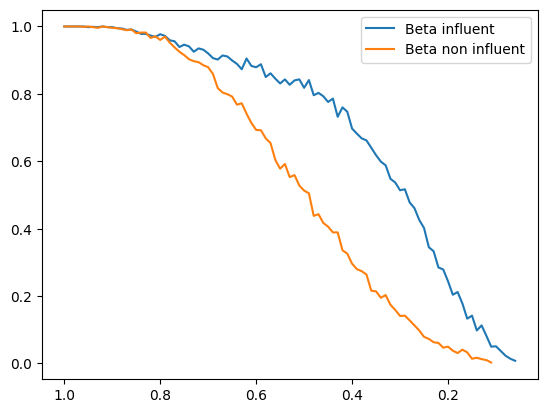

In [60]:
eps = jnp.array(eps).flatten()
eps2 = jnp.array(eps2).flatten()
accepts = jnp.array(accepts).flatten()
accepts2 = jnp.array(accepts2).flatten()
print('Len:', len(eps), len(accepts))
print('Len:', len(eps2), len(accepts2))
plt.plot(eps, accepts, label = "Beta influent")
plt.plot(eps2, accepts2, label = "Beta non influent")
plt.legend()
plt.gca().invert_xaxis()
# plt.xlim(.65,.38)